# Goal of the Notebook

This notebook is the first notebook we created, back in the first milestones when we wanted to find out about the data. We also the data in the 1K Dataset, which we will use everywhere in the rest of the project.

## Research questions

- **How to determine a similarity metric among artists, given a list of user-artist-plays tuples?**
    - From users' listening patterns on the 360K dataset, generate features to decide if an artist is more liked than another (ex : listened much more than the user's average per-artist plays)
    - Using SVD or matrix factorization using the previous features, generate a similarity feature space with respect to users and artists
- **How to compute a set of recommended artist, given previous similarity metrics, and a set of known-liked artists ?**
    - Find clustering of artists given similarity metric
    - Multiple ideas for generating the set : 
        - Use the mean of top artists of our users to determine a "center point" => may not be great, given that SVD isn't required to create a feature space that makes sense when we try to get the center (try to please everyone but please no one)
        - Pick artists that are close to each user's center point, but tends to be slightly biased towards others (please each user one at a time)
    
- **From a set of artists, how to compute the best fitting playlist ?**
    - Using other datasets, such as spotify's dataset, sample top tracks from our selected artist
    - More in depth : same analysis as before, but finding a set of music tracks using the 1K Dataset instead of the 360K

## Datasets used

**1) Last.fm Dataset - 360K users (user top artists)**

This dataset contains <user, artist-mbid, artist-name, total-plays> tuples (for ~360,000 users) collected from Last.fm API, using the user.getTopArtists() method.


**2) Last.fm Dataset - 1K users (user full listening history)**

This dataset contains <user-id, timestamp, artist-mbid, artist-name, song-mbid, song-title> tuples collected from Last.fm API, using the user.getRecentTracks() method.
The dataset represents the full listening history (till May, 5th 2009) for nearly 1,000 users.

## Libraries used

We may want to use dask dataframes (pandas dataframes divided in multiple partitions) if the pandas one doesn't fit into memory.

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import tarfile
from dask.delayed import delayed
import matplotlib.pyplot as plt

# Preprocessing

## Loading Data

Here we load the csv files into pandas dataframes

In [2]:
cols_1k   = ['userid','timestamp','musicbrainz-artist-id','artist-name','musicbrainz-track-id','track-name']
cols_360k = ['user-id','artist-id','artist-name','plays']

PATH_1k   = 'data/lastfm-dataset-1K.tar.gz'
PATH_360k = 'data/lastfm-dataset-360K.tar.gz'

PATH_1k_data   = 'lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv'
PATH_360k_data = 'lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'

with tarfile.open(PATH_1k, "r:*") as tar:
    df_1k = pd.read_csv(tar.extractfile(PATH_1k_data), sep="\t", error_bad_lines=False, header=0, names=cols_1k)

with tarfile.open(PATH_360k, "r:*") as tar:
    df_360k = pd.read_csv(tar.extractfile(PATH_360k_data), sep="\t", error_bad_lines=False, header=0, names=cols_360k)

b'Skipping line 2120260: expected 6 fields, saw 8\n'
b'Skipping line 2446318: expected 6 fields, saw 8\n'
b'Skipping line 11141081: expected 6 fields, saw 8\n'
b'Skipping line 11152099: expected 6 fields, saw 12\nSkipping line 11152402: expected 6 fields, saw 8\n'
b'Skipping line 11882087: expected 6 fields, saw 8\n'
b'Skipping line 12902539: expected 6 fields, saw 8\nSkipping line 12935044: expected 6 fields, saw 8\n'
b'Skipping line 17589539: expected 6 fields, saw 8\n'


In [3]:
df_1k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19098852 entries, 0 to 19098851
Data columns (total 6 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   userid                 object
 1   timestamp              object
 2   musicbrainz-artist-id  object
 3   artist-name            object
 4   musicbrainz-track-id   object
 5   track-name             object
dtypes: object(6)
memory usage: 874.3+ MB


We see that the timestamp is of type object, but we know that it is a date. We can therefore convert the column to a more narrow type.

In [4]:
df_1k['timestamp'] = pd.to_datetime(df_1k['timestamp'])

## Exploratory Data analysis

### Data Cleaning

#### We keep only user-ids that are valid

In [5]:
user_match = r'\Auser_\d{6}'

df_1k = df_1k[df_1k['userid'].str.fullmatch(user_match)]

#### We do the same, but this time for the artist ids and tracks ids (some are na by default, we just remove them as well) :

In [6]:
artist_track_match = r'\b([a-f0-9]{8})-([a-f0-9]{4})-([a-f0-9]{4})-([a-f0-9]{4})-([a-f0-9]{12})\b'

df_1k = df_1k[df_1k['musicbrainz-artist-id'].str.fullmatch(artist_track_match, na=False)]
df_1k = df_1k[df_1k['musicbrainz-track-id'].str.fullmatch(artist_track_match, na=False)]

#### We can now simply describe the dataset :

In [7]:
df_1k.describe()

<ipython-input-7-dd057528d907>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_1k.describe()


,userid,timestamp,musicbrainz-artist-id,artist-name,musicbrainz-track-id,track-name
count,16936134,16936134,16936134,16936134,16936134,16936134
unique,992,15631466,83905,81751,960402,693231
top,user_000949,2009-02-26 21:29:15+00:00,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,db16d0b3-b8ce-4aa8-a11a-e4d53cc7f8a6,Intro
freq,172042,193,111488,111488,3991,14908
first,NaN,2005-02-14 00:00:07+00:00,NaN,NaN,NaN,NaN
last,NaN,2013-09-29 18:32:04+00:00,NaN,NaN,NaN,NaN


After this simple cleaning, we still have around 17 million entries : this is nice because we have a lot of data, but we'll have to think about how to process it all efficiently. 

From this, we know that there are about a million different tracks in the dataset and a bit more than 80k unique artist-ids.
We can see that we

#### Since we dropped na artist ids, all those value are non na, what about other columns :

In [8]:
df_1k.isna().any()

userid                   False
timestamp                False
musicbrainz-artist-id    False
artist-name              False
musicbrainz-track-id     False
track-name               False
dtype: bool

### Let's explore :

#### Let's find more information about the average users

In [9]:
per_user_sets = df_1k.groupby('userid').agg(lambda x : set(x))

set_len = per_user_sets['musicbrainz-track-id'].apply(lambda x : len(x))

(set_len.mean(), set_len.std())

(3989.7247983870966, 4670.861545806167)

### Keeping only recent titles

In [10]:
df_1k['timestamp'].sort_values(ascending=False).head(5)

14293404   2013-09-29 18:32:04+00:00
7696483    2010-08-13 23:06:38+00:00
12032167   2009-06-19 21:31:16+00:00
18453009   2009-06-19 21:27:08+00:00
18453010   2009-06-19 21:23:17+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

Looks like there are some outliers, which we remove (3 tracks will not make a difference in our recommender):

In [11]:
df_1k = df_1k[df_1k['timestamp'] < '2010-08-12']

We can try to plot the amount of data per month :

Text(0.5, 0, 'month')

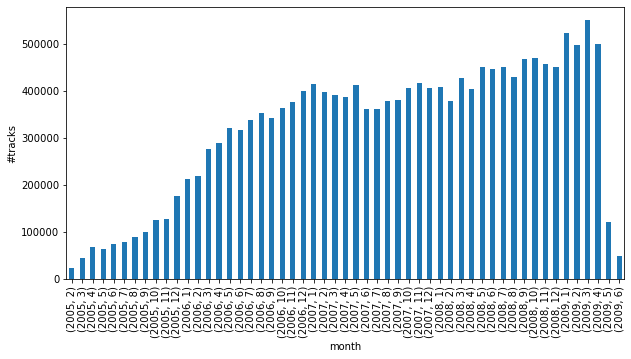

In [12]:
plt.figure(figsize=(10,5))
df_1k.groupby([df_1k["timestamp"].dt.year, df_1k["timestamp"].dt.month]).count()['userid'].plot(kind="bar")
plt.ylabel('#tracks')
plt.xlabel('month')

We make the choice of selecting the last six months, in order to keep relevant information (our tastes in music can change quite a lot)

Having a small interval is also a good choice because it ensures that older songs don't get more weight simply because they're older and have been listened to more 

In [13]:
df_1k = df_1k[('2008-11-01' < df_1k['timestamp']) & (df_1k['timestamp'] < '2009-05-01')]

We plot once again to make sure it looks normal : 

Text(0.5, 0, 'month')

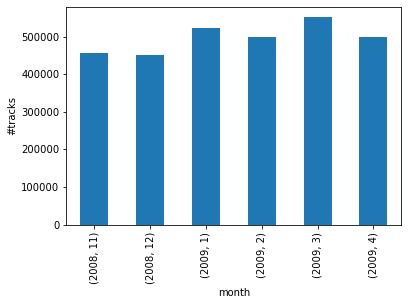

In [14]:
df_1k.groupby([df_1k["timestamp"].dt.year, df_1k["timestamp"].dt.month]).count()['userid'].plot(kind="bar")
plt.ylabel('#tracks')
plt.xlabel('month')

Get a dataframe grouped by track, with the number of plays, along with the track and artist name

In [15]:
df = df_1k.dropna().groupby('musicbrainz-track-id').agg((lambda x : x.iloc[0], lambda x : len(x)))[['artist-name', 'track-name', 'musicbrainz-artist-id']]
df.columns = ['artist-name', 'plays', 'track-name', 'torm1', 'musicbrainz-artist-id', 'torm2']
df = df[['artist-name', 'plays', 'track-name', 'musicbrainz-artist-id']]
df

,artist-name,plays,track-name,musicbrainz-artist-id
musicbrainz-track-id,,,,
00000baf-9215-483a-8900-93756eaf1cfc,In Extremo,1,Como Poden,8ebd161e-f45e-41b9-8019-fcbd094c327f
000011ea-a75a-4b4a-9ab7-e8b3c6c64705,Ember Swift,1,Cheap Drunk,4053e427-925c-4709-a86e-e1e04af0edf8
0000167c-95f5-48eb-b15f-04790e09a765,Sally Shapiro,3,He Keeps Me Alive (Skatebård Remix),076b616f-399d-41d6-881e-fcb47505912b
000067b7-dcad-4253-8a72-6db4bb029594,The Coral,1,Shes Got A Reason (Live),3b1c66fb-98ad-417f-b01e-49baf37f06a3
0000732b-9c3b-4808-8306-b2c970887465,Poisonblack,23,Lowlife,cef9233d-78ef-41d5-9bac-f2ca21aa4a40
...,...,...,...,...
ffff43cd-ab5f-443f-8f1d-a305dd8873a9,The Sword,12,The Sundering,40dc452a-6b63-4b7e-a106-062739155866
ffff748c-14d1-4e45-af10-2d255bff59f0,Wolfgang Amadeus Mozart,1,Cum Sancto Spiritu,b972f589-fb0e-474e-b64a-803b0364fa75
ffff8f29-0c47-4d58-b074-8dc2fddc000b,Scared Of Chaka,1,All My Friends Are Ghosts,411b8059-4a6c-48a5-8365-0a23b9faba26


#### Keeping only tracks played more than T times, plotting the remaining number of tracks and artists

In [16]:
ran = np.unique(np.geomspace(start=1,stop=df.plays.max(),num=20,dtype=int))

tot_tracks = []
tot_artists = []

for r in ran:
    filtered_df = df[df.plays > r].reset_index()
    total_tracks = len(filtered_df)
    total_artists = len(filtered_df['musicbrainz-artist-id'].unique())
    
    tot_tracks.append(total_tracks)
    tot_artists.append(total_artists)
    
threshold_df = pd.DataFrame({'tracks':tot_tracks, 'tot_artists':tot_artists})
threshold_df = threshold_df.set_index(ran)

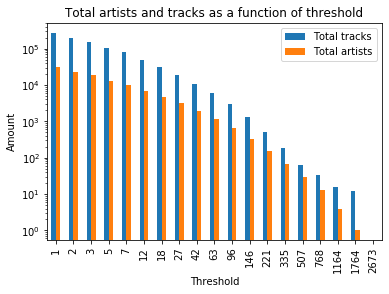

In [17]:
import matplotlib.pyplot as plt

threshold_df.plot(kind='bar', logy=True)
plt.legend(['Total tracks', 'Total artists'])
plt.gca().set(title='Total artists and tracks as a function of threshold', xlabel='Threshold', ylabel='Amount');

We wanted to keep a decent number of tracks and artists in order to make sure that we have enough data, but we also didn't want to have too many different tracks because we have to query the spotify API, which is why we chose to keep all tracks which were listened at least 50 times. Had we not used the spotify API, we would have probably kept the complete dataset, but since we wanted to provide different flavours of recommender systems, we had to make this tradeoff.

In [18]:
famous_tracks = df[df.plays > 50]
famous_tracks

,artist-name,plays,track-name,musicbrainz-artist-id
musicbrainz-track-id,,,,
00007960-9d81-4192-b548-ad33d6b0ca54,The Dandy Warhols,54,Not If You Were The Last Junkie On Earth,5f572b31-8fd9-45ae-9beb-358c98d839df
0003dd36-b4d2-4216-a37e-b110f6882ecb,Sigur Rós,71,Ný Batterí,f6f2326f-6b25-4170-b89d-e235b25508e8
00048f58-c10d-4dbe-a04f-e5b88a86ff61,José González,89,Killing For Love,cd8c5019-5d75-4d5c-bc28-e1e26a7dd5c8
000dbffe-59b2-42ba-9458-c8989dccaeb9,Depeche Mode,207,Little Soul,8538e728-ca0b-4321-b7e5-cff6565dd4c0
001d5305-dd07-4753-b722-90ac4b8ba05b,Chromeo,64,Momma'S Boy,647221d0-f6b1-4e03-924c-c59b8059536f
...,...,...,...,...
ffca7636-4b3c-4bfb-9df2-0899cfb69afc,Amy Winehouse,68,Addicted,dfe9a7c4-8cf2-47f4-9dcb-d233c2b86ec3
ffe2102d-4a5e-48b7-977a-0c28e2af119e,The Futureheads,133,Hounds Of Love,0cf9d983-aecf-4d57-9e94-fde2beac014f
ffe3798a-44fd-4795-969c-2e14fc7083c8,Friendly Fires,116,Photobooth,ef656595-bbe8-4386-8953-be8df9f54472


## Save Famous tracks dataset

In [ ]:
#famous_tracks.to_csv('data/famous_tracks.csv')

We see that on average, people listen to around 3989 tracks, with a standard deviation of 4670. We can conclude that there are a lot of different users type i.e user that listen a lot of tracks and others that rarly listen music